In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import pandas as pd
from geopy.geocoders import Nominatim
from matplotlib.colors import SymLogNorm
from matplotlib.pyplot import cm

import argparse

import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import dask
import utils

import geopandas

from numba import jit
import numpy as npF
from numba import guvectorize, float64, int64, void

import scipy.signal as signal


In [2]:
import sparse

In [22]:
years = 50
coal_year_range = [1]

country_emit = 'MALAYSIA'

## Add time dimension
length_simulation = years*365
time_array = np.arange(0, length_simulation)

## Days per season
season_days = {'DJF': 90, 'MAM':92, 'JJA':92, 'SON':91}


## import the china global powerplant database
### Gallagher, Kevin P. (2021), “China’s Global Energy Finance,” Global Development Policy Center, Boston University.
### Gallagher, Kevin P., Li, Zhongshu, Chen, Xu, Ma, Xinyue (2019), “China’s Global Power Database,” Global Development Policy Center, Boston University.

CGP_df = pd.read_csv('mod_coal_inputs/BC_limited_country_SEA_GAINS_Springer.csv')


CGP_df.columns = CGP_df.columns.str.replace(' ', '_')

CGP_df = CGP_df.rename(columns = {'YEAR':'Year_of_Commission', 'EMISFACTOR.PLATTS':'CO2_weighted_capacity_1000tonsperMW'})
min_year = CGP_df['Year_of_Commission'].min()
## reduce to one country for emissions

CGP_df = CGP_df.loc[CGP_df['COUNTRY'] == country_emit]
print('Emis data prepped and loaded')






Emis data prepped and loaded


In [23]:
######## Country mask and dataframe ######

country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_50
country_df = geopandas.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
countries = ['China','Australia', 'India','Myanmar', 'Cambodia', 'Laos','Philippines','Nepal','Bangladesh','Thailand','Bhutan','Brunei','Singapore', 'Papua New Guinea', 'Solomon Islands', 'East Timor', 'Taiwan']
country_df = country_df.rename(columns = {'SOVEREIGNT':'country'})

ds_area = xr.open_dataset('/net/fs11/d0/emfreese/GCrundirs/IRF_runs/stretch_2x_pulse/SEA/Jan/mod_output/GEOSChem.SpeciesConc.20160101_0000z.nc4', engine = 'netcdf4')
utils.fix_area_ij_latlon(ds_area);


######## Set health data #########

RR = 1.02 #global mean
del_x = 10 #ug/m3
beta = np.log(RR)/del_x


#2019 mortalities to match 2019 population data from the GBD #20+, all gender mortalities https://vizhub.healthdata.org/gbd-results/
I_val = {}
I_val['China'] = 10462043.68
I_val['Australia'] = 169053.20
I_val['Cambodia'] = 96284.85
I_val['Myanmar'] = 368031.84
I_val['Laos'] = 35874.09
I_val['Philippines'] = 557809.29
I_val['Nepal'] = 170032.44
I_val['Bangladesh'] = 740684.73
I_val['Thailand'] = 486556.52
I_val['Bhutan'] = 3713.40
I_val['East Timor'] = 6240.29
I_val['Solomon Islands'] = 5484.73
I_val['Brunei'] = 1790.80
I_val['Papua New Guinea'] = 49174.72
I_val['India'] = 8288847.22
I_val['Singapore'] = 23028.19
I_val['Taiwan'] = 183845.08


I_val_df = pd.DataFrame(I_val.values(), index = I_val.keys()).rename(columns = {0:'Ival'}) 
I_val_df.index.rename('country', inplace = True)
pop_df = country_df.loc[country_df['country'].isin(countries)].loc[country_df['POP_YEAR'] == 2019][['country','POP_EST']].set_index('country').groupby('country').max() #select 2019 population data
I0_pop_df = pd.merge(pop_df, I_val_df, left_index=True, right_index=True) #combine Initial mortality and total population by country
I0_pop_df['I_obs'] = I0_pop_df['Ival']/I0_pop_df['POP_EST'] #calculate initial mortality rate, I_obs

regrid_area_ds = xr.open_dataset('Outputs/regridded_population_data.nc')


####### Functions #########

def individual_plant_shutdown(years_running, df, time_array, typical_shutdown_years, unique_id):
    ''' Shutdown a unit early. The df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day
        years_running is the number of years the plant runs
        time_array is the length of time for our simulation
        shutdown_years is the typical lifetime of a coal plant
        unique_id is the unique identifier of a unit'''
    shutdown_days = typical_shutdown_years*365
    E = np.zeros(len(time_array))
    new_CGP = df.loc[df['unique_ID'] == unique_id]
    yr_offset = (new_CGP['Year_of_Commission'].iloc[0] - min_year)
    test_array = np.where((time_array <= (yr_offset + years_running)*365) & (time_array >= yr_offset * 365), True, False)
    E += test_array* new_CGP['BC_(g/day)'].sum()
    return(E)




########## Create emissions profile for each plant over our shutdown times ##########

E_CO2_all_opts = {}
for year in coal_year_range:
    E_CO2_all_opts[year] = {}
    for unique_id in CGP_df.loc[CGP_df['BC_(g/day)'] >0]['unique_ID'].values:
        E_CO2_all_opts[year][unique_id] = individual_plant_shutdown(year, CGP_df, time_array, 40, unique_id)
print('Emissions profiles based on individual plants created')



Emissions profiles based on individual plants created


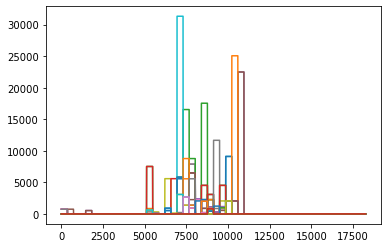

In [167]:
for unique_id in E_CO2_all_opts[1].keys():
    plt.plot(E_CO2_all_opts[1][unique_id])

In [5]:

############### Convolution, selection of location, health impact assessment ##########
    
## Convolve with G
country_emit_dict = {'INDONESIA':['Indo_Jan', 'Indo_Apr', 'Indo_July','Indo_Oct'], 'CAMBODIA':['Cambod_Jan', 'Cambod_Apr', 'Cambod_July','Cambod_Oct'] , 
               'MALAYSIA': ['Malay_Jan','Malay_Apr','Malay_July','Malay_Oct'], 'VIETNAM': ['Viet_Jan','Viet_Apr','Viet_July','Viet_Oct']}

#import the green's function and set our time step
G = xr.open_dataarray('Outputs/G_combined_new.nc', chunks = 'auto')
dt = 1 #day


G_lev0 = G.where(G.run.isin(country_emit_dict[country_emit]), drop = True).isel(lev = 0).compute()
G_lev0 = G_lev0.where((G_lev0 > 0), drop = True).rename({'time':'s'})
print('G prepped')
############################################

def np_to_xr_time_specific(C, G, E, time_init):
    C = xr.DataArray(
    data = C,
    dims = ['s','lat','lon'],
    coords = dict(
        s = (['s'], np.arange(time_init, C.shape[0] + time_init)), 
        lat = (['lat'], G.lat.values),
        lon = (['lon'], G.lon.values)
            )
        )
    return(C)

G prepped


In [18]:
np.unique([int(i/365) for i, x in enumerate(E_CO2_all_opts[yr][11]>0) if x])

array([0, 1])

In [24]:
E_CO2_all_opts[yr].keys()

dict_keys([3, 4, 7, 8, 9, 10, 17, 18, 21, 82, 132])

In [16]:
yr = 1
coal_year_range = [1]
for unique_id in CGP_df.loc[CGP_df['BC_(g/day)'] >0]['unique_ID']:
    print(unique_id)
    data = pd.DataFrame(columns = ['BC_mean_Conc','BC_pop_weight_mean_conc'], index = countries)
    #concentration
    #####start new#############
    C_conv = {}
    C_init = {}
    yr_range = np.unique([int(i/365) for i, x in enumerate(E_CO2_all_opts[yr][unique_id]>0) if x])[0]
    print(yr_range, 'year range')
    n = np.unique([int(i) for i, x in enumerate(E_CO2_all_opts[yr][unique_id]>0) if x])[0]
    for yr_num in [yr_range]:
        print(n, 'n')
        n_init = n


1
21 year range
7665 n
2
21 year range
7665 n
5
20 year range
7300 n
11
0 year range
0 n
12
0 year range
0 n
13
1 year range
365 n
14
0 year range
0 n
15
0 year range
0 n
24
26 year range
9490 n
24
26 year range
9490 n
25
23 year range
8395 n
26
23 year range
8395 n
27
14 year range
5110 n
29
14 year range
5110 n
30
14 year range
5110 n
31
4 year range
1460 n
32
4 year range
1460 n
34
20 year range
7300 n
37
26 year range
9490 n
38
20 year range
7300 n
39
27 year range
9855 n
40
27 year range
9855 n
44
24 year range
8760 n
45
24 year range
8760 n
46
26 year range
9490 n
49
21 year range
7665 n
50
21 year range
7665 n
51
21 year range
7665 n
52
21 year range
7665 n
53
17 year range
6205 n
54
19 year range
6935 n
54
19 year range
6935 n
55
19 year range
6935 n
56
20 year range
7300 n
57
21 year range
7665 n
58
22 year range
8030 n
59
22 year range
8030 n
60
21 year range
7665 n
61
21 year range
7665 n
62
14 year range
5110 n
63
15 year range
5475 n
71
17 year range
6205 n
74
17 year rang

In [ ]:

            for idx, season in enumerate(season_days.keys()):
                C_conv[season] = signal.convolve(G_lev0.sel(run = country_emit_dict[country_emit][idx]).fillna(0), 
                             E_CO2_all_opts[yr][unique_id][n:n+season_days[season]][..., None, None], mode = 'full')
                #switch the tail (that goes into the following months) to follow the GF of the next month 
                if idx == 0 or idx == 1 or idx == 2:
                    idx_next = idx + 1
                elif idx == 3:
                    idx_next = 0

                tail_switch = signal.convolve(G_lev0.sel(run = country_emit_dict[country_emit][idx_next]).fillna(0), 
                                     E_CO2_all_opts[yr][unique_id][n:n+season_days[season]][..., None, None], mode = 'full')

                C_conv[season][season_days[season]:tail_switch[season_days[season]:C_conv[season].shape[0]].shape[0]+season_days[season]] = tail_switch[season_days[season]:C_conv[season].shape[0]]

                n = n + season_days[season]

            C = {}

            C['DJF'] = sparse.COO.from_numpy(np.pad(C_conv['DJF'],((((0),
                                               (365 - len(C_conv['DJF'])))),
                                             (0,0),(0,0))))
            C['MAM'] = sparse.COO.from_numpy(np.pad(C_conv['MAM'],((((season_days['DJF']),
                                               (365 - season_days['DJF'] - len(C_conv['MAM'])))),
                                             (0,0),(0,0))))
            C['JJA'] = sparse.COO.from_numpy(np.pad(C_conv['JJA'],((((season_days['DJF'] + season_days['MAM'] ),
                                               (365 - season_days['DJF'] - season_days['MAM'] - len(C_conv['JJA'])))),
                                             (0,0),(0,0))))
            C['SON'] = sparse.COO.from_numpy(np.pad(C_conv['SON'][:season_days['SON']], ((((season_days['DJF'] + season_days['MAM'] + season_days['JJA']),
                                                (365 - season_days['DJF'] - season_days['MAM'] - season_days['JJA'] - len(C_conv['SON'][:season_days['SON']])))),
                                              (0,0),(0,0))))
            C_init[yr_num] = C['DJF']+C['MAM']+C['JJA']+C['SON']

        C_sum = C_init[yr_num]
        C_dense = sparse.COO.todense(C_sum)
        C_out = np_to_xr_time_specific(C_dense, G_lev0, E_CO2_all_opts[yr][unique_id], time_init = np.unique([i for i, x in enumerate(E_CO2_all_opts[yr][unique_id]>0) if x])[0])
        ### country level impacts ###
        mask = country_mask.mask(C_out, lon_name = 'lon', lat_name = 'lat')
        for country_impacted in countries:
            if country_impacted == 'East Timor':
                c_imp = 'Timor-Leste'
            elif country_impacted == 'Solomon Islands':
                c_imp = 'Solomon Is.'
            else:
                c_imp = country_impacted
            contiguous_mask = ~np.isnan(mask)& (mask == country_mask.map_keys(c_imp))
            country_impacted_ds = C_out.where(contiguous_mask)
            country_impacted_ds = country_impacted_ds.to_dataset(name = 'BC_conc')
            country_area = ds_area['area'].where(contiguous_mask)
            
            ## save out the concentrations and population weighted concentrations ##
            conc_mean_out = ((country_impacted_ds['BC_conc']*country_area).sum(dim = ['lat','lon'])/country_area.sum()).mean(dim = ['s']).values 
            pop_weight_conc = country_impacted_ds['BC_conc'].weighted(regrid_area_ds['regrid_pop_count']).mean(dim = ['lat','lon','s']).values
          
            data.loc[country_impacted] = [conc_mean_out, pop_weight_conc]
            print(data)